In [1]:
from functools import partial
from samplers import exponential_kernel, BlackOutSampler, MeanSampler, BlurSampler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import skimage.segmentation as seg

In [2]:
from samplers import LatentSampler
from models import GLOW
import torch
from torchvision import transforms

import pickle


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt', map_location='cuda'))

manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))
manipulators = torch.stack([v for k, v in manipulators.items()])

C:\Users\LuanAdemi\AppData\Roaming\Python\Python311\site-packages\torch\_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1994.)
  LU, pivots, infos = torch._lu_with_info(
C:\Users\LuanAdemi\AppData\Local\Temp\ipykernel_8808\1444963717.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code durin

In [3]:
image = Image.open("./data/000010.jpg")
image = np.array(image)

image = transform(image).numpy()

segmentation_fn = partial(seg.slic, n_segments=35, compactness=10)

kernel_fn = partial(exponential_kernel, kernel_width=0.25, distance_metric='cosine')
flow_sampler = partial(LatentSampler, kernel_fn=kernel_fn, model=flow, preprocessor=transform, manipulators=manipulators)
black_out_sampler = partial(BlackOutSampler, kernel_fn=kernel_fn)

from lime import ImageExplainer
from torchvision import models

model = models.resnet34(num_classes=40).to('cuda')
model.load_state_dict(torch.load('./models/resnet_celeba.pt', map_location='cuda', weights_only=True))

explainer1 = ImageExplainer(model, segmentation_fn, flow_sampler)
explainer2 = ImageExplainer(model, segmentation_fn, black_out_sampler)
explanation1 = explainer1.explain(image, 35, 1000)
explanation2 = explainer2.explain(image, 35, 1000)

100%|██████████| 1000/1000 [00:02<00:00, 493.28it/s]


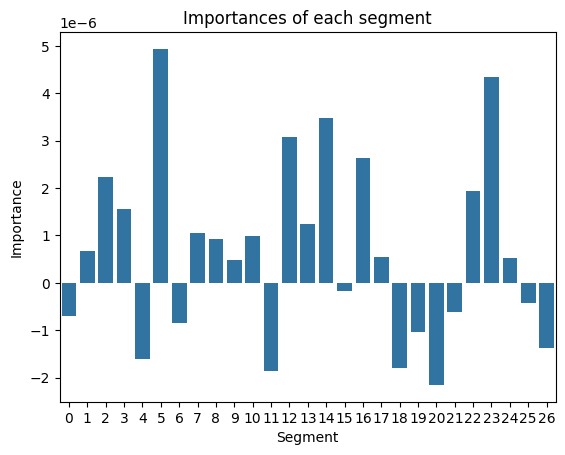

In [4]:
explanation1.plot_importances()

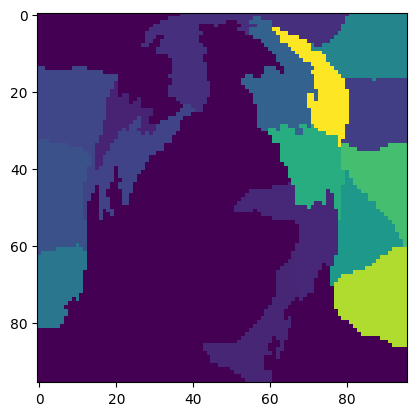

In [5]:
explanation1.render(positive_only=True)

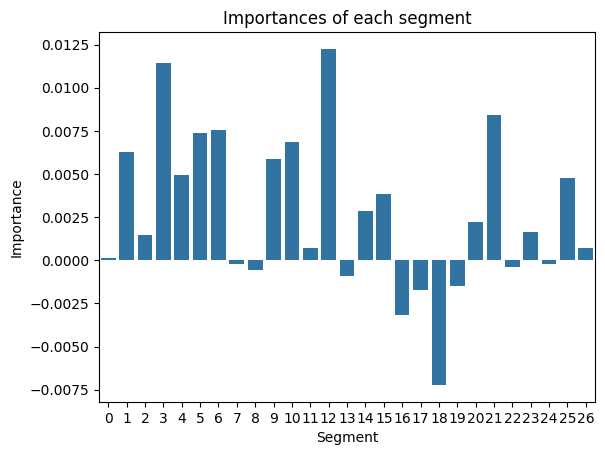

In [6]:
explanation2.plot_importances()

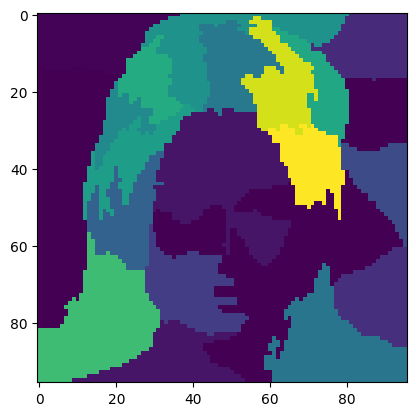

In [7]:
explanation2.render(positive_only=True)